In [1]:
from salad.serialize import read, write
from salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog
import astropy.table
import os
from functools import lru_cache
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import numpy as np

In [2]:
"""
I want to look at a way to filter out false positive detections

This will involve looking at at how the coadded flux scales with N per Pedro's paper


I can do forced photometry two ways:
- measure at each point in a cluster: this lets me filter points and refine the line
- measure at each point predicted by a line in all exposures: this lets me verify a line is real
"""

"\nI want to look at a way to filter out false positive detections\n\nThis will involve looking at at how the coadded flux scales with N per Pedro's paper\n\n\nI can do forced photometry two ways:\n- measure at each point in a cluster: this lets me filter points and refine the line\n- measure at each point predicted by a line in all exposures: this lets me verify a line is real\n"

In [3]:
def load_clusters(pg, detector, snr):
    search_path = f"../search/new_pipeline/DEEP/{pg}/detector_{detector}/snr_{snr}/unshuffled"
    
    catalog = read(os.path.join(search_path, "..", "catalog.pkl"))
    recovery = read(os.path.join(search_path, "recovery.pkl"))
    catalog_findable = read(os.path.join(search_path, "catalog_detectable.pkl"))
    search_findable = read(os.path.join(search_path, "search_detectable.pkl"))
    detector_fakes = read(os.path.join(search_path, "..", "..", "fakes.pkl"))
    clusters = read(os.path.join(search_path, "refined_clusters_2.pkl"))
    measurements = list(map(read, map(str, Path(search_path).rglob("cluster_*_forced.pkl"))))
    return catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters, measurements

In [4]:
catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters, measurements = load_clusters(
    "20190403/A0c", 1, 5.0
)

In [5]:
import lsst.afw.image
import lsst.geom

In [6]:
ic = read("../search/new_pipeline/DEEP/20190403/A0c/detector_1/images.pkl")

In [7]:
import astropy.time
import numpy as np
import astropy.units as u

images = [image for image in ic.images]
exposures = []
times = []
for image in images:
    visit_info = image.reader.readExposureInfo().getVisitInfo()
    time = visit_info.date.toAstropy() + astropy.time.TimeDelta(visit_info.exposureTime / 2 + 0.5, format='sec')
    times.append(time.value)


In [73]:
measurements[0].extra['measurement']

i_x,i_y,ra,dec,exposures,time,peakValue,significance,forced_flux,forced_mag,forced_mag_err_low,forced_mag_err_high,forced_a,forced_c
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1491.0,1846.0,216.1212636627186,-11.099294496995872,845931.0,58577.31759259151,9.31640911102295,6.3533549308776855,1455.8798162175506,23.30763800476362,-0.13395253810468333,-0.15283595617363588,2.7363010127812457e-05,0.03983725415603857
1491.0,1855.0,216.12174087345673,-11.099217294799892,845929.0,58577.314166565426,14.010692596435547,8.461941719055176,1655.8721864565266,23.185218213924284,-0.10461674273882693,-0.11578259841542504,3.5645929543391934e-05,0.0590251032912917
1492.0,1860.0,216.122101822537,-11.099227622183626,845928.0,58577.31245103199,12.548775672912598,7.653780937194824,1542.9820971967306,23.262715468533138,-0.11154645888487735,-0.12433268983653889,3.587688576094298e-05,0.05535739243230732
1493.0,1868.0,216.12385437670537,-11.099214776885626,845922.0,58577.30216465937,45.25774383544922,25.594818115234375,4022.180577161251,22.22790097479981,-0.04122123100960451,-0.042848216236876624,4.12803088334122e-05,0.16603685640896856
1491.0,1871.0,216.12413541266176,-11.099197071862136,845921.0,58577.300449041184,60.13294982910156,31.873271942138672,4506.194969841623,22.111789489085357,-0.03458825803400245,-0.0357264950897509,4.700015286814649e-05,0.21179185243622906
1495.0,1877.0,216.12444769374775,-11.099222751924074,845920.0,58577.298730730545,66.7147445678711,37.24369430541992,5597.385586363445,21.871697987144188,-0.029831505695135263,-0.03067436388824163,4.113087207175516e-05,0.2302253504890011
1493.0,1885.0,216.12474823074953,-11.09930993492634,845919.0,58577.29700846039,49.14563751220703,29.09428596496582,4627.972599562235,22.072604869059322,-0.03732436425065799,-0.03865328410625679,3.816890742014369e-05,0.17664465769565266
1493.0,1889.0,216.12505711905132,-11.099233576135491,845918.0,58577.295296105556,87.36824798583984,48.25294494628906,7259.594480531974,21.588758092729094,-0.023546187498588722,-0.024068170986311088,3.9477280190842846e-05,0.28658904537985697
1486.0,1895.0,216.12540613017006,-11.099373497387461,845917.0,58577.2935738028,48.517311096191406,31.166576385498047,5393.144018438553,21.898693446943682,-0.035044021118388,-0.03621296221029269,3.19507771294063e-05,0.17231514255992092


In [11]:
line = measurements[0].extra['line']

In [18]:
line.beta.shape

(1, 2)

In [23]:
(times[:, None] @ line.beta) + line.alpha

<Quantity [[216.11685909, -11.09885692],
           [216.11716218, -11.0988722 ],
           [216.12601685, -11.0993187 ],
           [216.11746793, -11.09888762],
           [216.12172555, -11.09910231],
           [216.13492975, -11.09976813],
           [216.11618723, -11.09882304],
           [216.11526977, -11.09877678],
           [216.12875632, -11.09945683],
           [216.11062203, -11.09854242],
           [216.11990014, -11.09901027],
           [216.11868389, -11.09894894],
           [216.12571178, -11.09930331],
           [216.12845305, -11.09944154],
           [216.11001428, -11.09851177],
           [216.13280233, -11.09966085],
           [216.13705555, -11.09987532],
           [216.11557422, -11.09879213],
           [216.11191225, -11.09860748],
           [216.12632177, -11.09933407],
           [216.12723783, -11.09938027],
           [216.10910022, -11.09846568],
           [216.11655495, -11.09884158],
           [216.12324597, -11.09917898],
           [216.

In [77]:
pc = ic.images[0].exposure.getPhotoCalib()
zp = pc.instFluxToMagnitude(1)

31.217706456070967

In [58]:
ic.images[0].exposure.getInfo().getVisitInfo().getId()

845945

In [65]:
lsst.geom.Extent2I(20, 20)

Extent2I(20, 20)

In [63]:
ic.images[0].reader.re

In [41]:
np.bitwise_or.reduce(ic.images[0].exposure.mask.array.flatten())

60831

In [135]:
cluster = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_forced_points.pkl")
x = cluster.extra['forced_points']
x


i_x,i_y,ra,dec,exposures,time,peakValue,significance,forced_logL,forced_a,forced_c,forced_flux,forced_sigma,forced_SNR,forced_mag,forced_sigma_mag_high,forced_sigma_mag_low,forced_mask,forced_zero_point,forced_i_x,forced_i_y,forced_exposure,forced_detector,forced_time
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int64,int64,Time
163.0,2809.0,216.19189138530163,-11.002743309295953,845975.0,58577.393984940834,482.87158203125,309.4004821777344,-1065.6562751332563,8.040678385612382e-06,0.8879622560582242,110433.74868059675,352.6579302539457,313.14693136511755,18.47614681421917,-0.00347272600963322,-0.0034616539041714134,18432,31.083901350644805,163.0,2809.0,845975,1,58577.39328470934
165.0,2807.0,216.19218334528878,-11.002912064298085,845974.0,58577.39226360712,477.5310974121094,309.7838134765625,-1003.3173557504049,8.090107609538615e-06,0.8924768486624419,110317.05531458814,351.5789387026938,313.77606326946596,18.478892245851913,-0.0034657519484220245,-0.0034547241985798394,18432,31.08549889767791,165.0,2807.0,845974,1,58577.39156337559
176.0,2818.0,216.19246938430845,-11.003112793424084,845973.0,58577.390541809145,427.37384033203125,299.43414306640625,-1108.7561041359306,7.722009690321851e-06,0.8404778633478741,108841.8555601221,359.8610384452426,302.4552366946047,18.48007435173233,-0.003595689245130984,-0.003583820508932689,18432,31.07206419453132,176.0,2818.0,845973,1,58577.389841577344
172.0,2824.0,216.1927128238547,-11.003253763594476,845972.0,58577.388831184246,533.734130859375,318.8716735839844,-993.0311658167408,8.420985527054493e-06,0.939333479409659,111546.73955819286,344.60259181582813,323.6967515839483,18.486535984285087,-0.0033593687610427025,-0.003349006614968175,18432,31.105178185904663,172.0,2824.0,845972,1,58577.388130952524
176.0,2816.0,216.1930052891909,-11.003419652996946,845971.0,58577.387109267525,438.46514892578125,299.36322021484375,-1063.371195267943,7.892719091621213e-06,0.8524185747530053,108000.62245442379,355.9480982228287,303.4167705731464,18.490747212543013,-0.0035842756039876633,-0.0035724819735314384,18432,31.074312858847016,176.0,2816.0,845971,1,58577.38640903578
178.0,2823.0,216.19328123094144,-11.003548144501922,845970.0,58577.385399164166,653.1431274414062,337.6451721191406,-1718.631696758517,9.64274569225288e-06,1.0700251790148363,110966.8566572807,322.0324553650107,344.5828357005329,18.51458311779744,-0.003155452281617954,-0.0031463082258191832,18432,31.12756632782217,178.0,2823.0,845970,1,58577.384698932656
187.0,2831.0,216.19351253945294,-11.00376495949218,845969.0,58577.38366577728,708.4180908203125,346.611083984375,-1844.0975239266145,1.0079037973716947e-05,1.1249237774935636,111610.23308246494,314.98542549819257,354.33459470684426,18.517664310454602,-0.0030684872075106284,-0.003059839540906495,18432,31.136924348201944,187.0,2831.0,845969,1,58577.38296554581
185.0,2829.0,216.19380772000193,-11.00390004640939,845968.0,58577.38195688883,504.4386901855469,316.5804443359375,-1010.0409813590662,8.597672577023578e-06,0.9442311077806425,109824.0366007896,341.0433212336354,322.0237130096251,18.505827671656586,-0.0033768491593235694,-0.003366379062264002,18432,31.107571177238746,185.0,2829.0,845968,1,58577.38125665714
194.0,2838.0,216.19404887136682,-11.00408304889303,845967.0,58577.38024196215,660.9109497070312,346.3147277832031,-1629.0841223269335,9.819459217731438e-06,1.1086662153167375,112905.01755073937,319.1216101874357,353.7993477922875,18.512655907242944,-0.0030731359579583284,-0.0030644621061384214,18432,31.14443901374221,194.0,2838.0,845967,1,58577.37954173052


In [127]:
cluster = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_10_forced_line.pkl")
x = cluster.extra['forced_line']
x

i_x,i_y,ra,dec,forced_logL,forced_a,forced_c,forced_flux,forced_sigma,forced_SNR,forced_mag,forced_sigma_mag_high,forced_sigma_mag_low,forced_mask,forced_zero_point,forced_i_x,forced_i_y,forced_exposure,forced_detector,forced_time,clipped
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int64,int64,Time,bool
608.2965843081193,3906.6910640375527,216.27101900532034,-11.034641035625555,-250.28391835026653,1.3405667113379672e-05,0.008468858725244062,631.737208869794,273.1214343496015,2.3130268423427958,24.216365312865737,-0.6147676705441825,-0.3901107046289134,0,31.217706456070967,608.2965843081193,3906.6910640375527,845945,1,58577.340923087984,False
612.7991734331201,3899.7688560660063,216.2712005636604,-11.034710463791725,-216.05016274127294,9.129596473477622e-06,0.004308656187934394,471.9437710583885,330.95901008265804,1.4259885867452862,24.52376638674774,-1.3117952151917116,-0.5769317595424219,0,31.208492032836443,612.7991734331201,3899.7688560660063,845944,1,58577.33921306838,False
611.6734033137275,3942.913419787851,216.27650480652574,-11.036738813777902,-229.07408866895395,1.0600002837729567e-05,0.005121321407415335,483.1433996589646,307.14751730369574,1.573001155601889,24.51789952500485,-1.096433859609661,-0.5342773489661496,18444,31.228089652284762,611.6734033137275,3942.913419787851,845915,1,58577.289254695235,False
615.0363995004975,3908.0597114613583,216.27138371901037,-11.034780502657213,-214.6608120354761,1.180215224505148e-05,0.00644017689444087,545.6781746855679,291.0847100789993,1.8746370241757906,24.36932353704529,-0.8277233315923809,-0.4641645617606578,0,31.211664996529827,615.0363995004975,3908.0597114613583,845943,1,58577.33748800722,False
614.6987632369853,3896.300070446685,216.2739341781671,-11.035755801852247,-235.20291153334867,1.3099944469957572e-05,0.008920987489925272,680.9942981349268,276.2900675861442,2.4647802365266003,24.14992655331079,-0.565014328400995,-0.36974372617484974,2048,31.232785242421297,614.6987632369853,3896.300070446685,845929,1,58577.313466333726,False
628.9858360098169,3978.8735444519034,216.28184393188621,-11.03878050287949,-223.3962038640641,1.0875336729388012e-05,0.001474371838587512,135.5702241939206,303.23452284834724,0.44708044097512467,25.894080666626024,nan,-1.275267507322269,0,31.22449145224817,628.9858360098169,3978.8735444519034,845886,1,58577.238967778925,False
602.5861099737583,3867.535926392323,216.27061654120735,-11.034487132778395,-203.20247283483988,7.840932302289578e-06,0.002991873047639868,381.5710852096289,357.1216240172081,1.0684625616264634,24.74933114295773,-2.983265411117472,-0.717220888566974,0,31.20326978596184,602.5861099737583,3867.535926392323,845947,1,58577.34471372368,False
610.3448323355055,3848.8386492692894,216.2700669465512,-11.03427696700328,-210.5610710929849,1.1712658112060457e-05,0.0023435711132479913,200.08874935355874,292.1946546047412,0.6847789519771457,25.450265787421614,nan,-0.977481313078723,0,31.20332246164791,610.3448323355055,3848.8386492692894,845950,1,58577.34989011843,False
633.7718881840683,3947.567743334398,216.27814583967665,-11.037366347179614,-205.4285548306387,9.961793005786327e-06,-0.0030313696774882386,-304.2996050738518,316.83360824775826,-0.9604397928514419,nan,nan,nan,18432,31.22732572122532,633.7718881840683,3947.567743334398,845906,1,58577.27379851259,False


In [128]:
def convert_flux(data, zp, flux_key="forced_flux", zero_point_key="forced_zero_point"):
    return data[flux_key] * 10**(-2/5 * (data[zero_point_key] - zp))


def convert_zp(flux, orig, new):
    return flux * 10**(-2/5*(orig - new))

In [274]:
isinstance("a", str)

True

In [81]:
read(
    "/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_forced_points.pkl"
).extra



{'line': <salad.regression.RegressionResult at 0x7f61e64651d0>,
 'join': <Table length=16>
   i_x     i_y           ra         ...     peakValue         significance   
 float64 float64      float64       ...      float64            float64      
 ------- ------- ------------------ ... ------------------ ------------------
   547.0  1871.0 216.12198928874378 ...  4.741759777069092  3.305917739868164
   550.0  1871.0 216.12306185812653 ...  6.641977310180664 3.9471166133880615
   579.0  1923.0 216.12502955107058 ... 6.1281352043151855 3.6322453022003174
   574.0  1914.0   216.125855626097 ...  6.737199783325195  4.373503684997559
   573.0  1911.0 216.12611279303508 ...  5.346153259277344  3.559985637664795
   567.0  1906.0 216.12663365159148 ... 10.041837692260742  7.326117515563965
   558.0  1923.0 216.12751782491947 ...  5.413218021392822  3.432002544403076
   555.0  1933.0 216.12802681197962 ...  5.757731914520264  3.285419464111328
   568.0  1945.0  216.1283976796301 ...  9.23207473

In [80]:
read(
    "/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_forced_line.pkl"
).extra



{'line': <salad.regression.RegressionResult at 0x7f61e503f4d0>,
 'join': <Table length=16>
   i_x     i_y           ra         ...     peakValue         significance   
 float64 float64      float64       ...      float64            float64      
 ------- ------- ------------------ ... ------------------ ------------------
   547.0  1871.0 216.12198928874378 ...  4.741759777069092  3.305917739868164
   550.0  1871.0 216.12306185812653 ...  6.641977310180664 3.9471166133880615
   579.0  1923.0 216.12502955107058 ... 6.1281352043151855 3.6322453022003174
   574.0  1914.0   216.125855626097 ...  6.737199783325195  4.373503684997559
   573.0  1911.0 216.12611279303508 ...  5.346153259277344  3.559985637664795
   567.0  1906.0 216.12663365159148 ... 10.041837692260742  7.326117515563965
   558.0  1923.0 216.12751782491947 ...  5.413218021392822  3.432002544403076
   555.0  1933.0 216.12802681197962 ...  5.757731914520264  3.285419464111328
   568.0  1945.0  216.1283976796301 ...  9.23207473

In [72]:
cutouts = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_1_cutouts.pkl")


In [74]:
len(cutouts.extra['cutouts'])

102

In [87]:
cluster_line.extra['forced_line']

i_x,i_y,ra,dec,forced_logL,forced_a,forced_c,forced_flux,forced_sigma,forced_SNR,forced_mag,forced_sigma_mag_high,forced_sigma_mag_low,forced_mask,forced_zero_point,forced_i_x,forced_i_y,forced_exposure,forced_detector,forced_time,clipped
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int64,int64,Time,bool
565.3218733055489,2016.3996546707099,216.13035178919563,-11.031156225644736,-242.5559360995799,1.7445535051176535e-05,0.0022667035265920795,129.93029562823367,239.41858136920092,0.5426909427212404,25.933430389586928,nan,-1.1343158907404849,1024,31.217706456070967,565.3218733055489,2016.3996546707099,845945,1,58577.340923087984,False
569.9560841973541,2011.884911536878,216.1307202273183,-11.031225049659497,-215.66895728853444,1.0043058818654466e-05,0.004039079831859429,402.17625972249067,315.5491371025691,1.2745281556316326,24.69745095579615,-1.6669063539264215,-0.628854708165111,1024,31.208492032836443,569.9560841973541,2011.884911536878,845944,1,58577.33921306838,False
568.3127034690447,2128.2496788036533,216.141484179514,-11.033235749302094,-265.0482059769321,1.4457212123489181e-05,-0.011114402588933875,-768.7791044357634,263.0011959520521,-2.9231011731821934,nan,nan,nan,0,31.228089652284762,568.3127034690447,2128.2496788036533,845915,1,58577.289254695235,False
572.0010323095128,2022.7107580070613,216.13109190627256,-11.031294479058943,-237.23885462844683,1.0366917040655248e-05,0.007744515886258091,747.0413678325908,310.58121772834346,2.4053011746705386,24.028303367078415,-0.5835001352344591,-0.3774651620781597,1024,31.211664996529827,572.0010323095128,2022.7107580070613,845943,1,58577.33748800722,False
571.6453591187319,2046.1436697456886,216.1362675781129,-11.032261291372379,-235.55727208411147,1.2231871795267316e-05,0.0015988941913550037,130.71541446123058,285.92592827862575,0.45716530588248205,25.941968231757564,nan,-1.2585888948018322,1024,31.232785242421297,571.6453591187319,2046.1436697456886,845929,1,58577.313466333726,False
585.1576861628907,2238.0181877964574,216.15231891909934,-11.035259671986296,-229.11837509342485,1.2177507180818653e-05,-0.011760493695718095,-965.7554309836569,286.5634537797497,-3.37012769159995,nan,nan,nan,0,31.22449145224817,585.1576861628907,2238.0181877964574,845886,1,58577.238967778925,False
559.635958220213,1971.5044502015326,216.12953506481244,-11.031003662033072,-230.14318675749035,7.631038126058604e-06,0.0025248800440203084,330.8697980944825,361.99968140580916,0.914005771523237,24.904126969902123,nan,-0.8024857622754666,1024,31.20326978596184,559.635958220213,1971.5044502015326,845947,1,58577.34471372368,False
567.5368965332259,1945.2949641666642,216.12841976697382,-11.030795325083545,-218.95399393885,1.0049949527737976e-05,0.013161482975068431,1309.6068730238483,315.4409410296896,4.151670575001825,23.410470097508046,-0.29920517242423017,-0.23431299541523387,1024,31.20332246164791,567.5368965332259,1945.2949641666642,845950,1,58577.34989011843,False
590.4302239992578,2155.712627650352,216.14481434422123,-11.0338578220194,-233.61290074870922,1.2746372692660829e-05,0.009100405981779072,713.9604498634305,280.0958625330266,2.5489860628671237,24.093140334928474,-0.5407998767529598,-0.3593420824185749,1024,31.22732572122532,590.4302239992578,2155.712627650352,845906,1,58577.27379851259,False


In [92]:
def plot_cluster_cutouts(
    cluster, 
    cutouts=None,
    cols=None, rows=None, 
    component="", 
    title="{visit}\n({x}, {y})\nSNR={significance:0.1f}", 
    show_colorbar=False, 
    highlight_points=True,
    limit=None,
    stretch="linear",
    scale="zscale",
    **kwargs
):
    import matplotlib.pyplot as plt
    import lsst.afw.display as afwDisplay
    import numpy as np
    
    if "forced_line" in cluster.extra:
        catalog = cluster.extra['forced_line']
        cutouts = np.array(cluster.extra['cutouts'])
        get_significance = lambda row : row['forced_SNR']
        exposure_col = "forced_exposure"
    elif "forced_points" in cluster.extra:
        catalog = cluster.extra['forced_points']
        if cutouts is None:
            raise Exception("must pass cutouts if plotting forced_points cluster")

        get_significance = lambda row : row['forced_SNR']      
        exposure_col = "forced_exposure"      
    else:
        catalog = cluster.extra['join']
        cutouts = cluster.extra['cutouts']
        get_significance = lambda row : row['significance']
        exposure_col = "exposures"
    
    idx = np.argsort(catalog[exposure_col])
    catalog = catalog[idx]
    cutouts = np.array(cutouts)[idx]
    
    if limit:
        cutouts = cutouts[:limit]
        catalog = catalog[:limit]
        
    included_exposures = np.unique(cluster.extra['join']['exposures'])
    
    afwDisplay.setDefaultBackend("matplotlib")
    if rows is not None and cols is None:
        cols = len(cutouts) / rows
    elif rows is None and cols is not None:
        rows = len(cutouts) / cols
    elif rows is None and cols is None:
        cols = round((len(cutouts))**0.5 + 0.5)
        rows = len(cutouts)/cols
                
    if cols > len(cutouts):
        cols = len(cutouts)
        rows = 1

    if (cols - int(cols)) != 0:
        cols += 1
    cols = int(cols)
        
    if (rows - int(rows)) != 0:
        rows += 1
    rows = int(rows)

        
    print(rows, cols)
    fig = plt.figure(figsize=(cols*2, rows*2), **kwargs)
    axs = fig.subplots(rows, cols)
    axs = np.atleast_2d(axs)
    display = afwDisplay.Display(frame=fig)
    display.scale(stretch, scale)
    
    for ax, row, cutout in zip(axs.flatten(), catalog, cutouts):
        plt.sca(ax)
        a = cutout
        if component:
            a = getattr(cutout, component)
        display.mtv(a)

        visit = cutout.getInfo().getVisitInfo().getId()
        x = int(row['i_x'])
        y = int(row['i_y'])
        significance = get_significance(row)
        plt.title(title.format(**locals()))

        if highlight_points:
            if np.isin(visit, included_exposures):
                ax.spines['bottom'].set_color('red')
                ax.spines['top'].set_color('red')
                ax.spines['left'].set_color('red')
                ax.spines['right'].set_color('red')

        display.show_colorbar(show=show_colorbar)
        
    return fig, axs





In [95]:
vars()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'from salad.serialize import read, write\nfrom salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog\nimport astropy.table\nimport os\nfrom functools import lru_cache\nimport matplotlib.pyplot as plt\nfrom tqdm import tqdm\nfrom pathlib import Path\nimport numpy as np',
  '"""\nI want to look at a way to filter out false positive detections\n\nThis will involve looking at at how the coadded flux scales with N per Pedro\'s paper\n\n\nI can do forced photometry two ways:\n- measure at each point in a cluster: this lets me filter points and refine the line\n- measure at each point predicted by a line in all exposures: this lets me verify a line is real\n"""',
  'def load_clusters(pg, detecto

In [ ]:
fig.savefig()

4 4


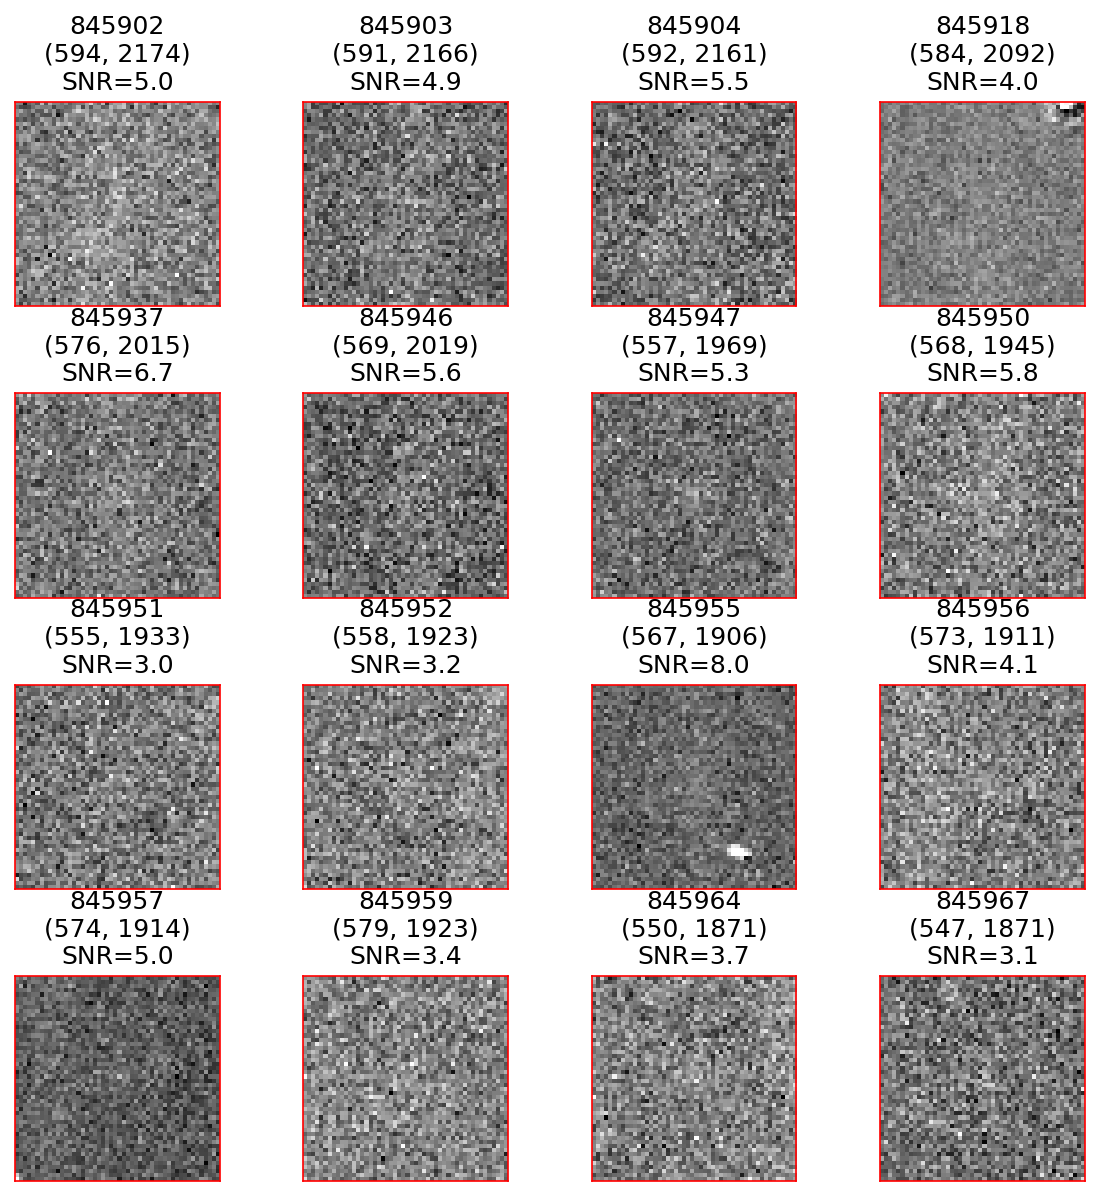

In [93]:
cluster_cutouts = read(
    "/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_cutouts.pkl"
)
cluster_points = read(
    "/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_forced_points.pkl"
)
fig, axs = plot_cluster_cutouts(
    cluster_points, cutouts=cluster_cutouts.extra['cutouts'], dpi=150, component="image", limit=16
)
for ax in axs.flatten():
#     ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
fig.show()

4 4


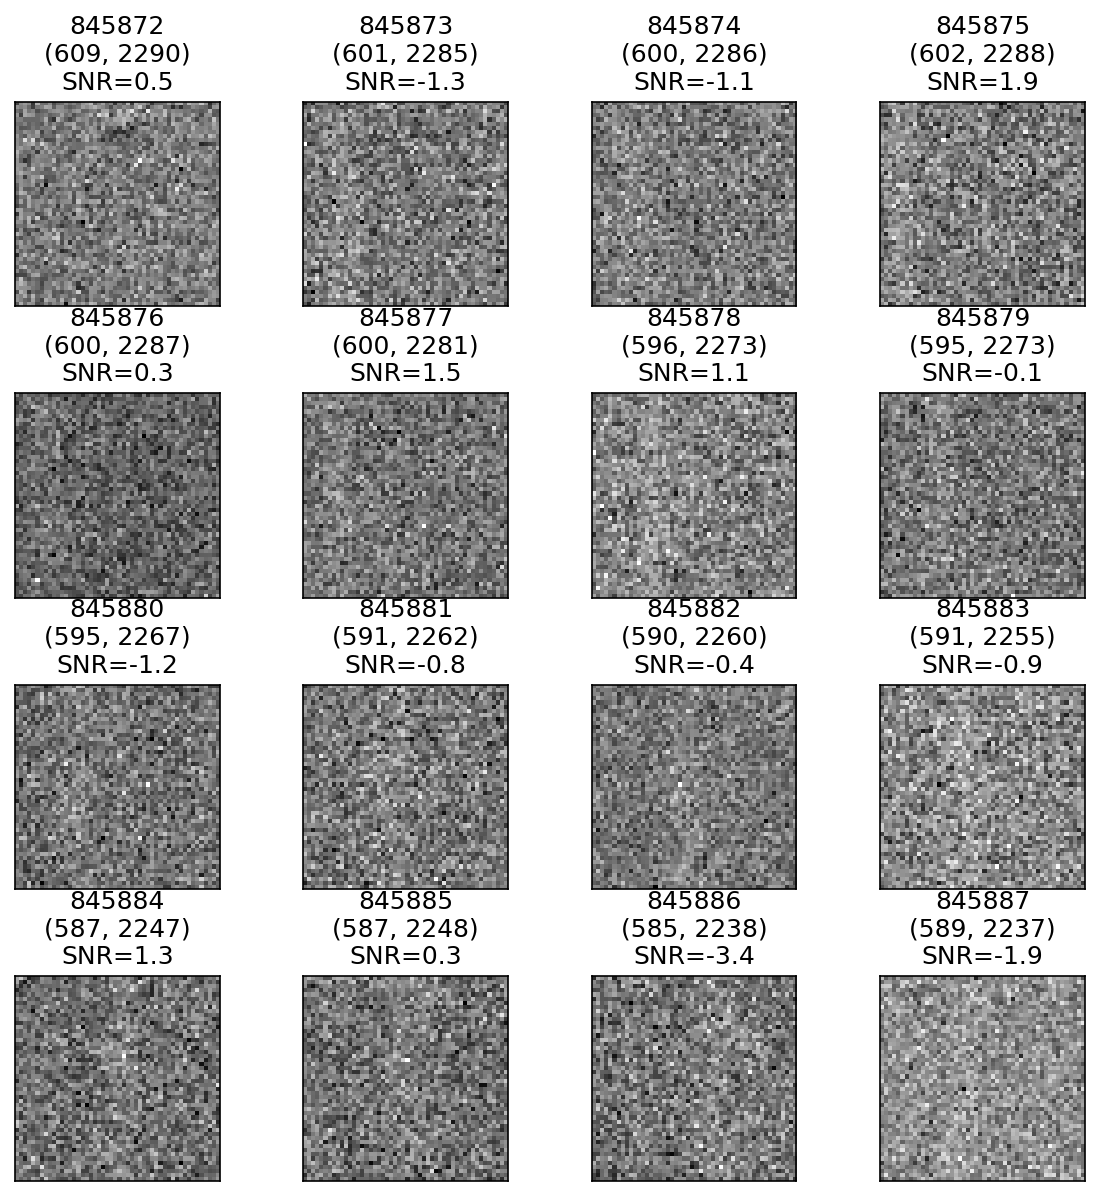

In [94]:
cluster_line = read(
    "/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_forced_line.pkl"
)
fig, axs = plot_cluster_cutouts(cluster_line, dpi=150, component="image", limit=16)
for ax in axs.flatten():
#     ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
fig.show()

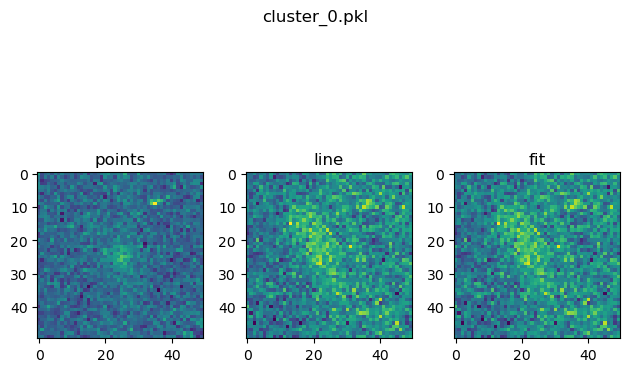

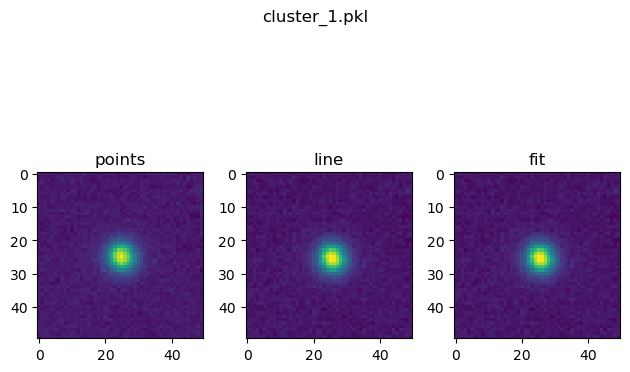

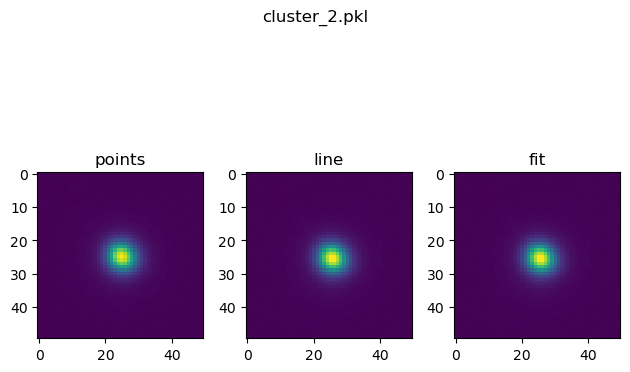

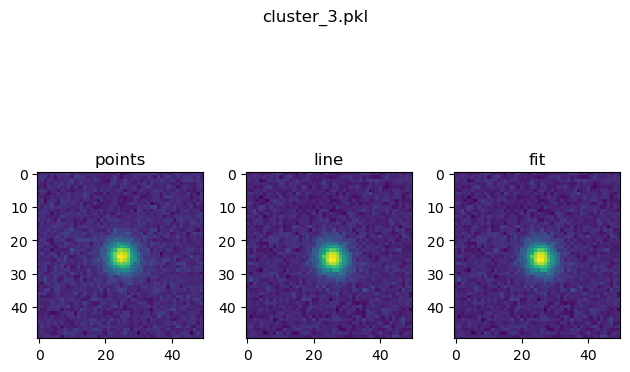

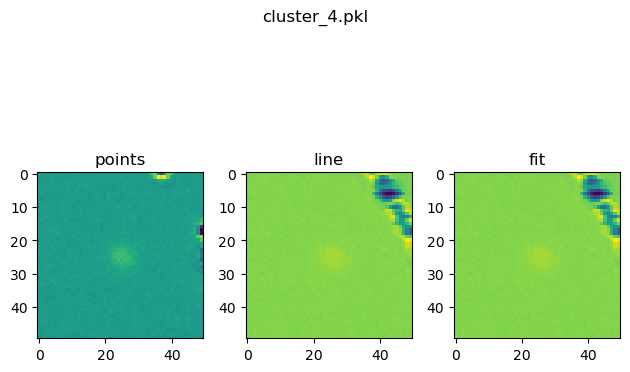

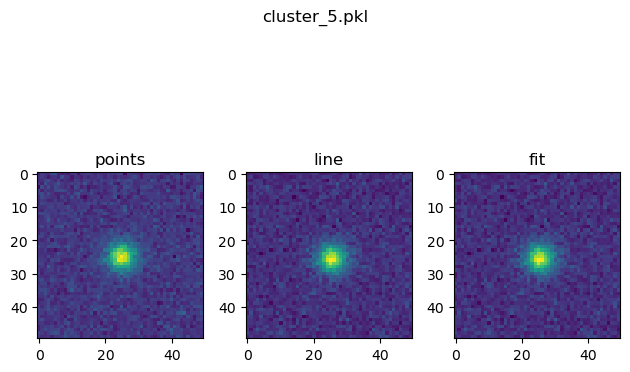

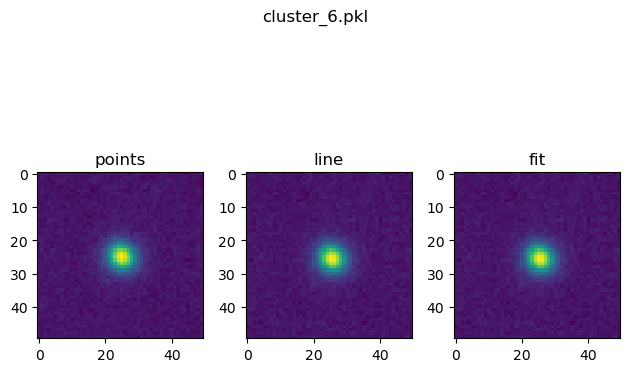

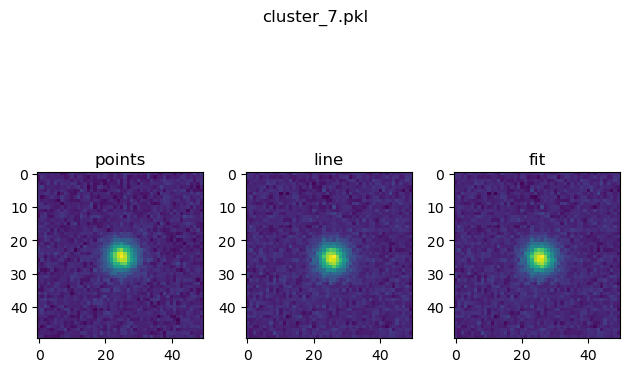

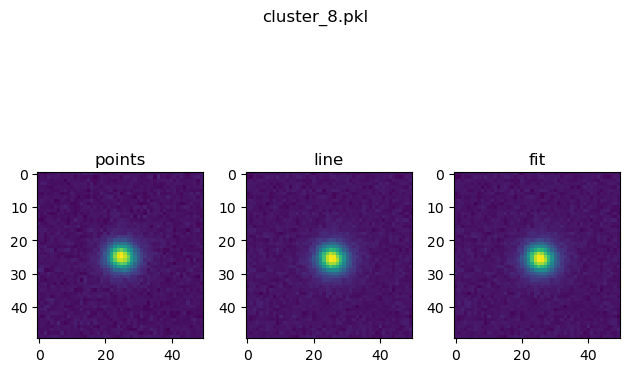

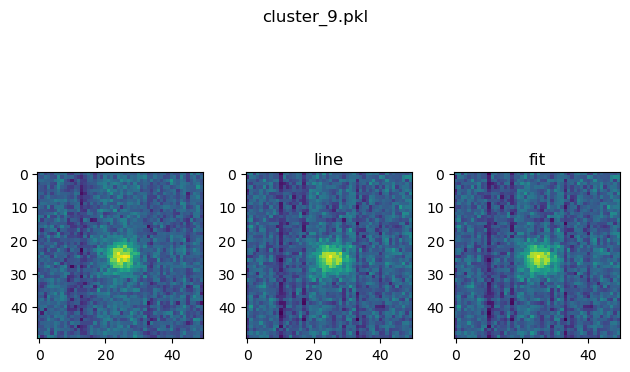

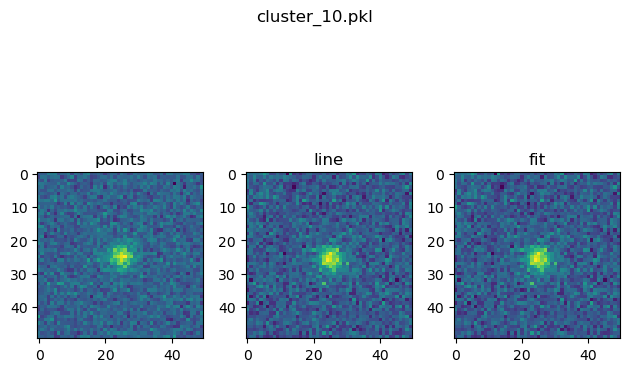

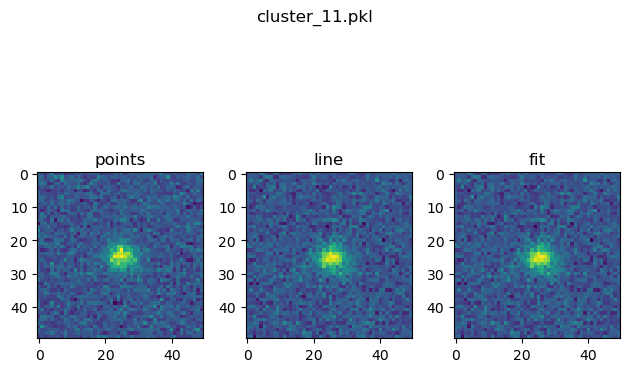

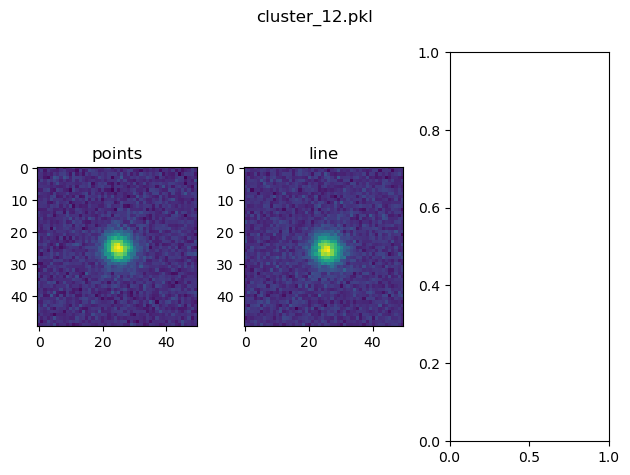

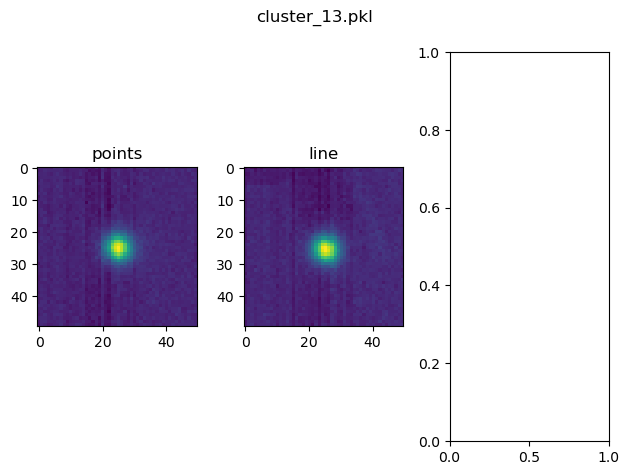

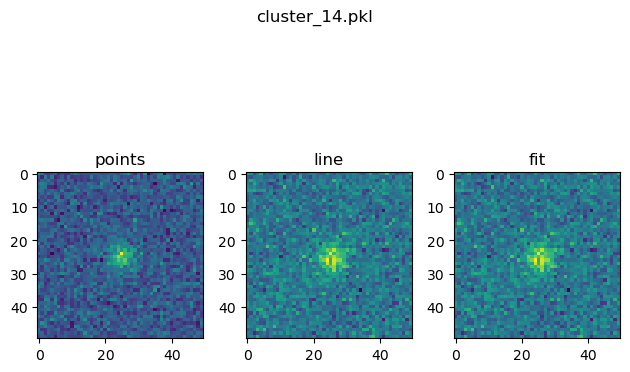

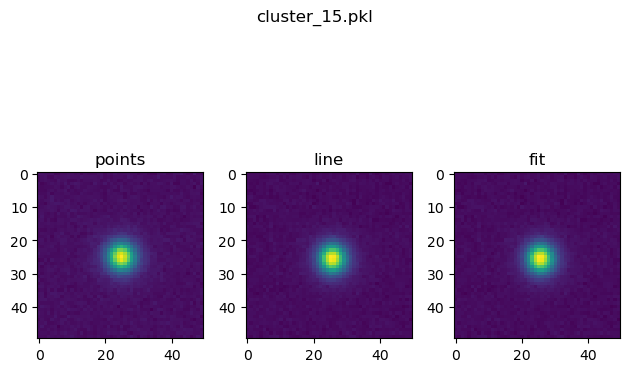

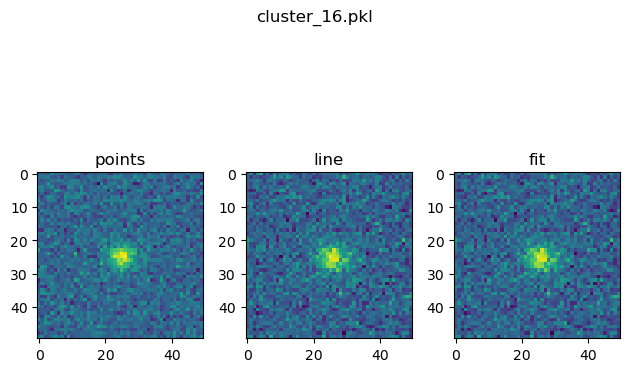

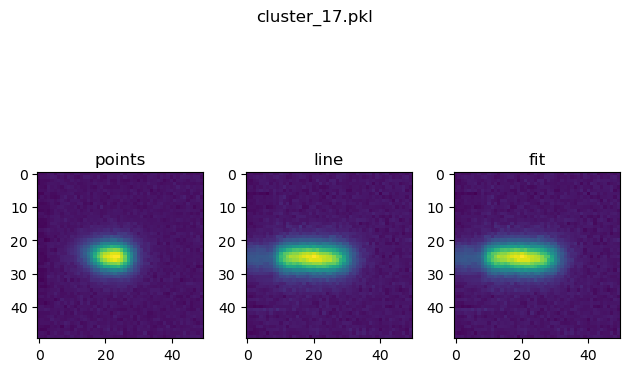

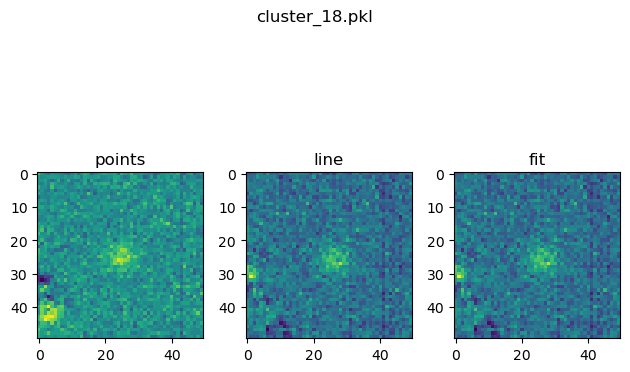

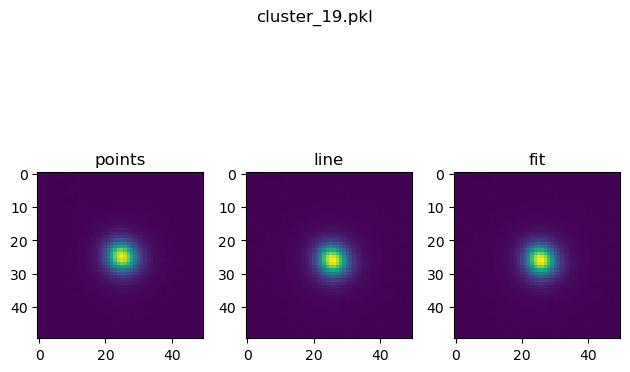

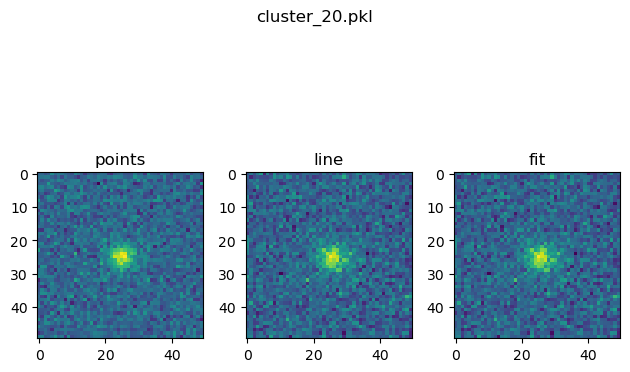

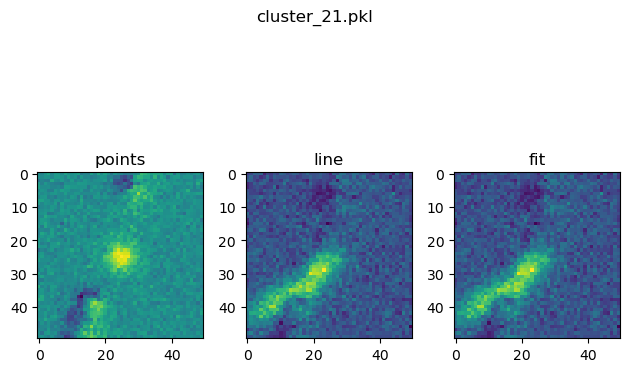

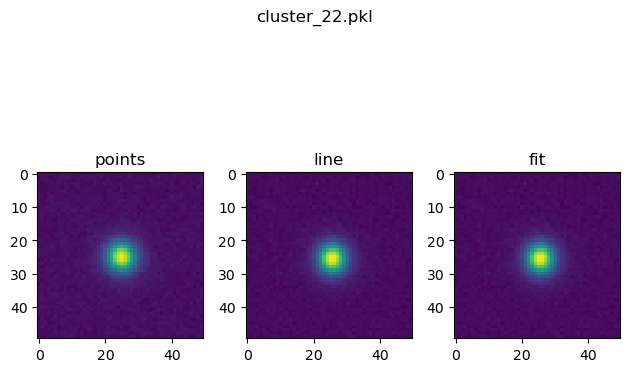

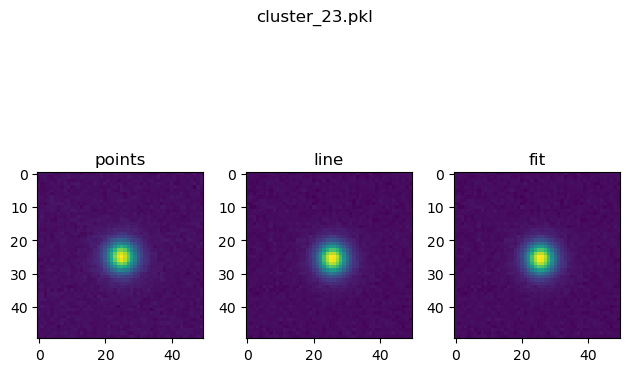

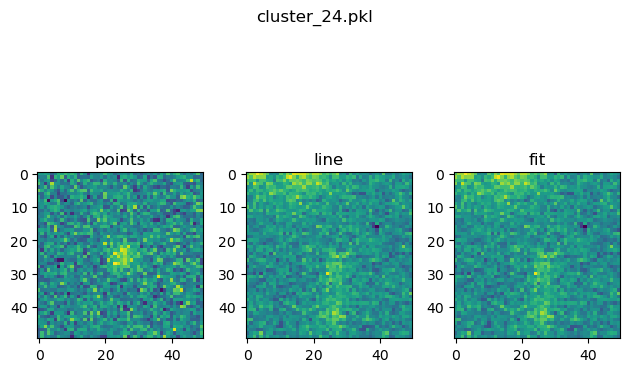

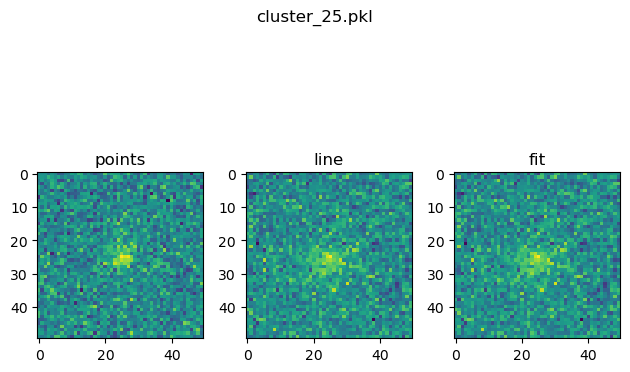

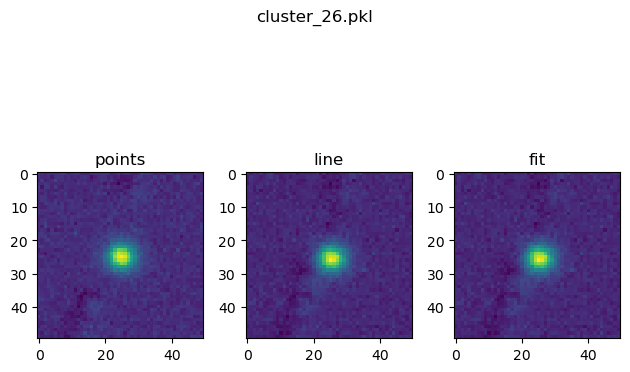

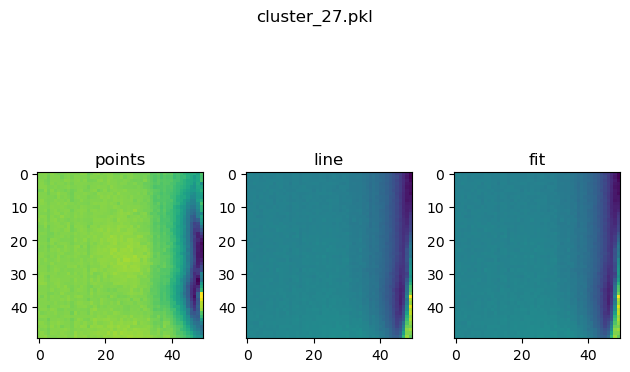

In [11]:
import re

detector = 1
snr = 3.0
pg = "20190403/A0c"
prefix = f"/epyc/projects/salad/search/new_pipeline/DEEP/{pg}/detector_{detector}/snr_{snr}/unshuffled/refined_clusters_2_filtered_joined_split"
clusters = filter(lambda x : re.compile("cluster_\d+.pkl").match(x.name), Path(prefix).rglob("cluster_*.pkl"))

for i, cluster in enumerate(clusters):
    fig, axs = plt.subplots(1, 3)
    try:
        coadd = read(cluster.parent / cluster.name.replace(".pkl", "_coadd_points.pkl"))
        plt.sca(axs[0])
        plt.imshow(coadd)
        plt.title("points")
    except FileNotFoundError:
        pass

    try:
        coadd = read(cluster.parent / cluster.name.replace(".pkl", "_coadd_line.pkl"))
        plt.sca(axs[1])
        plt.imshow(coadd)
        plt.title("line")
    except FileNotFoundError:
        pass
    
    try:
        coadd = read(cluster.parent / cluster.name.replace(".pkl", "_coadd_fit_line.pkl"))
        plt.sca(axs[2])
        plt.imshow(coadd)
        plt.title("fit")
    except FileNotFoundError:
        pass
    
    fig.suptitle(cluster.name)
    fig.tight_layout()
    plt.show()

In [248]:
cluster_cutouts = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_17_cutouts.pkl")


In [211]:
images = [image for image in ic]

In [249]:
times = []
cutouts = []
for image in images:
    visit_info = image.reader.readExposureInfo().getVisitInfo()
    time = visit_info.date.toAstropy() + astropy.time.TimeDelta(visit_info.exposureTime / 2 + 0.5, format='sec')
    times.append(time.value)
times = np.array(times) * u.day
times

<Quantity [58577.34162332, 58577.3399133 , 58577.28995493, 58577.33818824,
           58577.31416657, 58577.23966801, 58577.34541396, 58577.35059035,
           58577.27449874, 58577.37681305, 58577.32446558, 58577.33132773,
           58577.29167613, 58577.27620981, 58577.38024196, 58577.25167099,
           58577.22767416, 58577.34887263, 58577.36953356, 58577.28823456,
           58577.2830661 , 58577.38539916, 58577.34333931, 58577.30558831,
           58577.35403168, 58577.31930518, 58577.25853316, 58577.35918179,
           58577.29529611, 58577.39054181, 58577.31759259, 58577.24652481,
           58577.33475461, 58577.36091074, 58577.29700846, 58577.32103757,
           58577.37165146, 58577.22595067, 58577.26539429, 58577.21560552,
           58577.28477227, 58577.37336543, 58577.37852533, 58577.31245103,
           58577.30216466, 58577.24824257, 58577.33304222, 58577.36435972,
           58577.27105677, 58577.38883118, 58577.35746809, 58577.3471386 ,
           58577.32789804

In [250]:
def get_positions(cluster, times):
    line = cluster.extra['line']
    positions = (times[:, None] @ line.beta) + line.alpha
    return positions

positions = get_positions(cluster_cutouts, times)
positions

cutouts = []
clipped = []
points = []
cutout_width = 50
cutout_height = 50
for position, image in zip(positions, images):
    wcs = image.reader.readWcs()
    exposure_bbox = image.reader.readBBox()
    point = wcs.skyToPixel(lsst.geom.SpherePoint(position[0].to(u.deg).value, position[1].to(u.deg).value, units=lsst.geom.degrees))
    bbox = lsst.geom.Box2I(lsst.geom.Point2I(point.getX() - cutout_width/2, point.getY() - cutout_height/2), lsst.geom.Extent2I(cutout_width, cutout_height))
    bbox.clip(exposure_bbox) # clip to fit the cutout in the exposure
    clipped.append((bbox.width != cutout_width) or (bbox.height != cutout_height)) # indicate if the box was clipped off; this might be picked up as a EDGE mask too...
    cutouts.append(image.reader.read(bbox))
    points.append(point)

line = cluster_cutouts.extra['line']
trajectory_fit = fit_trajectory(cutouts, points, times, lambda p, t : p[0] * t + p[1], start=[line.beta.value, line.alpha.value])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [254]:
np.hstack([line.beta.value.flatten(), line.alpha.value.flatten()])

array([-1.76862418e-01,  8.64489079e-03,  1.05762472e+04, -5.17493619e+02])

In [252]:
from salad.measure.fitting import fit_trajectory
trajectory_fit = fit_trajectory(cutouts, points, times.value, lambda p, t : (p[0] * t + p[2], p[1] * t + p[3]), start=np.hstack([line.beta.value.flatten(), line.alpha.value.flatten()]))


In [256]:
trajectory_fit

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 306535.4609699162
             x: [-1.769e-01  8.645e-03  1.058e+04 -5.175e+02]
           nit: 79
          nfev: 232
 final_simplex: (array([[-1.769e-01,  8.645e-03,  1.058e+04, -5.175e+02],
                       [-1.769e-01,  8.645e-03,  1.058e+04, -5.175e+02],
                       ...,
                       [-1.769e-01,  8.645e-03,  1.058e+04, -5.175e+02],
                       [-1.769e-01,  8.645e-03,  1.058e+04, -5.175e+02]]), array([ 3.065e+05,  3.065e+05,  3.065e+05,  3.065e+05,
                        3.065e+05]))

In [253]:
trajectory_fit.x

array([-1.76862419e-01,  8.64489057e-03,  1.05762472e+04, -5.17493975e+02])

In [167]:
cutouts = [cutout.image.array for cutout in cluster_cutouts.extra['cutouts']]

In [169]:
shapes = set(list(map(lambda x : x.shape, cutouts)))
shapes

{(50, 50)}

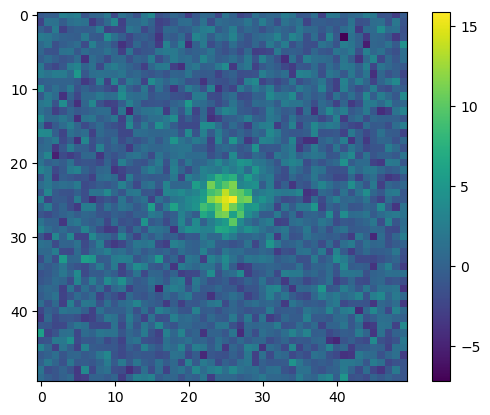

In [166]:
plt.imshow(np.nanmean(c, axis=0))
plt.colorbar()
plt.show()

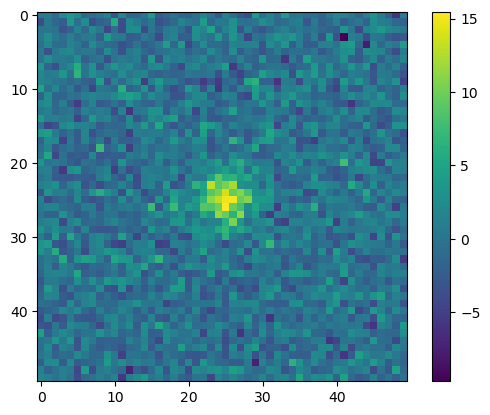

In [165]:
plt.imshow(np.nanmedian(c, axis=0))
plt.colorbar()
plt.show()

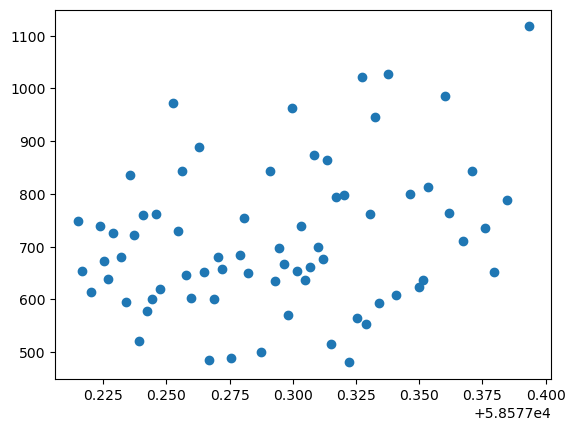

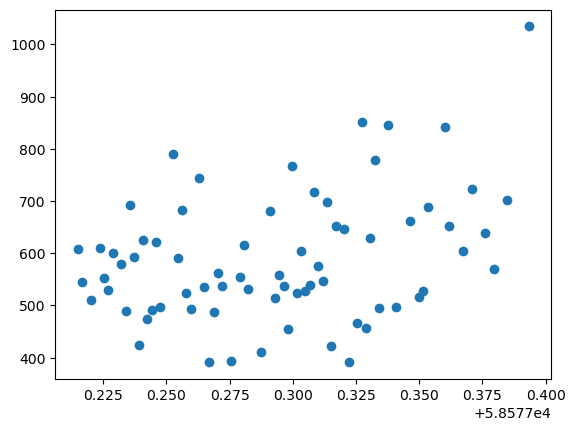

24.30966174154517

In [141]:
cluster = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_10_forced_points.pkl")
x = cluster.extra['forced_points']

plt.scatter(x['forced_time'].value, x['forced_flux'])
plt.show()

plt.scatter(x['forced_time'].value, convert_zp(x['forced_flux'], x['forced_zero_point'], 31))
plt.show()

# scale c and a by zero point
c_scaled = convert_zp(convert_zp(x['forced_c'], x['forced_zero_point'], 31), x['forced_zero_point'], 31)
a_scaled = convert_zp(x['forced_a'], x['forced_zero_point'], 31)
assert(np.allclose((c_scaled/a_scaled), convert_zp(x['forced_flux'], x['forced_zero_point'], 31)))
c_coadd = c_scaled.sum()
a_coadd = a_scaled.sum()
snr_coadd = c_coadd / (a_coadd**0.5)
snr_coadd

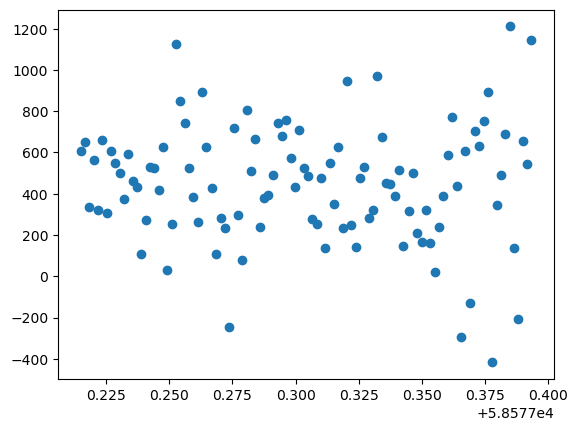

In [ ]:
plt.scatter()

13.460896464587835

In [108]:
convert_zp(x['forced_flux'], x['forced_zero_point'], 31)[0]

96788.03215993995

1868.8514314707672

In [60]:
cluster = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_0_forced.pkl")
cluster.extra['measurement']

i_x,i_y,ra,dec,exposures,time,peakValue,significance,forced_flux,forced_mag,forced_mag_err_low,forced_mag_err_high,forced_a,forced_c
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
163.0,2809.0,216.19189138530163,-11.002743309295953,845975.0,58577.393984940834,482.87158203125,309.4004821777344,110433.74868059675,18.47614681421917,-0.0034616539041714134,-0.00347272600963322,8.040678385612382e-06,0.8879622560582242
165.0,2807.0,216.19218334528878,-11.002912064298085,845974.0,58577.39226360712,477.5310974121094,309.7838134765625,110317.05531458814,18.478892245851913,-0.0034547241985798394,-0.0034657519484220245,8.090107609538615e-06,0.8924768486624419
176.0,2818.0,216.19246938430845,-11.003112793424084,845973.0,58577.390541809145,427.37384033203125,299.43414306640625,108841.8555601221,18.48007435173233,-0.003583820508932689,-0.003595689245130984,7.722009690321851e-06,0.8404778633478741
172.0,2824.0,216.1927128238547,-11.003253763594476,845972.0,58577.388831184246,533.734130859375,318.8716735839844,111546.73955819286,18.486535984285087,-0.003349006614968175,-0.0033593687610427025,8.420985527054493e-06,0.939333479409659
176.0,2816.0,216.1930052891909,-11.003419652996946,845971.0,58577.387109267525,438.46514892578125,299.36322021484375,108000.62245442379,18.490747212543013,-0.0035724819735314384,-0.0035842756039876633,7.892719091621213e-06,0.8524185747530053
178.0,2823.0,216.19328123094144,-11.003548144501922,845970.0,58577.385399164166,653.1431274414062,337.6451721191406,110966.8566572807,18.51458311779744,-0.0031463082258191832,-0.003155452281617954,9.64274569225288e-06,1.0700251790148363
187.0,2831.0,216.19351253945294,-11.00376495949218,845969.0,58577.38366577728,708.4180908203125,346.611083984375,111610.23308246494,18.517664310454602,-0.003059839540906495,-0.0030684872075106284,1.0079037973716947e-05,1.1249237774935636
185.0,2829.0,216.19380772000193,-11.00390004640939,845968.0,58577.38195688883,504.4386901855469,316.5804443359375,109824.0366007896,18.505827671656586,-0.003366379062264002,-0.0033768491593235694,8.597672577023578e-06,0.9442311077806425
194.0,2838.0,216.19404887136682,-11.00408304889303,845967.0,58577.38024196215,660.9109497070312,346.3147277832031,112905.01755073937,18.512655907242944,-0.0030644621061384214,-0.0030731359579583284,9.819459217731438e-06,1.1086662153167375


In [44]:
lsst.afw.image.MaskX(ic.images[0].exposure.mask, lsst.geom.Box2I(lsst.geom.Point2I(10, 10), lsst.geom.Point2I(30, 30)))

lsst.afw.image._image.MaskX=[[389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 389 389]
 [389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389 389
  389 38

In [42]:
ic.images[0].exposure.mask

lsst.afw.image._image.MaskX=[[405 405 405 ... 405 405 405]
 [405 405 405 ... 405 405 405]
 [405 405 405 ... 405 405 405]
 ...
 [405 405 405 ... 405 405 405]
 [405 405 405 ... 405 405 405]
 [405 405 405 ... 405 405 405]], bbox=(minimum=(0, 0), maximum=(2047, 4095)), maskPlaneDict={'BAD': 0, 'CLIPPED': 9, 'CR': 3, 'CROSSTALK': 10, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'FAKE': 11, 'INEXACT_PSF': 12, 'INJECTED': 13, 'INJECTED_TEMPLATE': 14, 'INTRP': 2, 'NOT_DEBLENDED': 15, 'NO_DATA': 8, 'REJECTED': 16, 'SAT': 1, 'SENSOR_EDGE': 17, 'STREAK': 18, 'SUSPECT': 7, 'UNMASKEDNAN': 19}

In [30]:
%%time
ic.images[2].exposure

CPU times: user 19 µs, sys: 3 µs, total: 22 µs
Wall time: 25.5 µs


In [15]:
%%time
exposure = ic.images[1].read(lsst.geom.Box2I(lsst.geom.Point2I(10, 10), lsst.geom.Point2I(30, 30)))

CPU times: user 141 ms, sys: 10.9 ms, total: 152 ms
Wall time: 141 ms


In [8]:
exposure.image

lsst.afw.image._image.ImageF=[[2.3772943 2.3586512 2.3418703 2.3263605 2.3116434 2.297002  2.2824237
  2.2679563 2.2534757 2.2390468 2.2247343]
 [2.3712425 2.3525739 2.3358881 2.3203504 2.3056674 2.2910597 2.2764544
  2.2619605 2.2475142 2.2331207 2.2187836]
 [2.365246  2.3466105 2.3298967 2.3144553 2.2997456 2.2851112 2.2705395
  2.2560802 2.2416077 2.227249  2.2129457]
 [2.3593621 2.3407605 2.3240194 2.3085501 2.2938738 2.2792733 2.2647362
  2.2502499 2.2358124 2.221426  2.2070973]
 [2.3535144 2.3348856 2.3181787 2.302743  2.28804   2.2734735 2.2589085
  2.244456  2.2299917 2.21564   2.201346 ]
 [2.3476396 2.3290453 2.312372  2.29691   2.282242  2.2677093 2.2531772
  2.2386985 2.2242677 2.2099507 2.195629 ]
 [2.341922  2.3233001 2.3066607 2.2911716 2.2765377 2.2619781 2.2474818
  2.2329767 2.2185805 2.2042363 2.1899483]
 [2.3361788 2.3175898 2.3009229 2.2854676 2.270868  2.256282  2.24182
  2.2273493 2.212988  2.1986172 2.1843634]
 [2.330472  2.3119173 2.2952843 2.2798629 2.2652347 2

In [23]:
measurements[1].extra['join']

i_x,i_y,ra,dec,exposures,time,peakValue,significance,forced_flux,forced_mag,forced_mag_err_low,forced_mag_err_high,forced_a,forced_c
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
82.0,631.0,216.03096102116575,-10.995179072010774,845964.0,58577.37509831553,8.552313804626465,5.101328372955322,987.6871399175388,23.688480613585977,-0.20539993876174734,-0.25354192040909496,2.3634933158526336e-05,0.02334391953348708
148.0,682.0,216.0341072455164,-10.999920150130649,845949.0,58577.34887263365,9.039198875427246,5.644628524780273,1046.4709985423121,23.644749683719684,-0.18293322221067143,-0.22012774252990752,2.7114938991823385e-05,0.028374997282187293
142.0,694.0,216.03438431931409,-11.000114489844442,845948.0,58577.34713859856,10.548473358154297,6.098414421081543,1042.0805989193673,23.661175431654584,-0.1718764308529508,-0.20429798651804987,3.1300842335277486e-05,0.03261800052742665
166.0,727.0,216.03526130317343,-11.0015058619245,845944.0,58577.33991330024,8.431360244750977,5.2951531410217285,942.2272486630582,23.773102883768424,-0.19529339837556847,-0.23829763417175087,2.900509050807317e-05,0.027329386626644768
174.0,737.0,216.03556497006554,-11.00201164112638,845943.0,58577.33818823891,8.479560852050781,5.190667629241943,896.1684467046294,23.83069087472213,-0.19841954488718727,-0.24297505309482403,3.096879085379836e-05,0.027753253195769014
173.0,727.0,216.03564919746404,-11.002247380923246,845942.0,58577.33647356043,9.725263595581055,6.186859130859375,1146.0054753247948,23.558242409891896,-0.16463203262886594,-0.19413573422708197,2.840284253580068e-05,0.03254981306081556
176.0,720.0,216.0360410684487,-11.002494620934774,845941.0,58577.33475460578,7.567346572875977,5.169894695281982,993.1353578592278,23.706743176360018,-0.19897912525791028,-0.24381586796515364,2.5061661893261764e-05,0.024889622552911495
184.0,723.0,216.03617474132122,-11.002690188665843,845940.0,58577.33304221975,11.318985939025879,6.994438171386719,1238.2864138002653,23.47860009899194,-0.14938893109397355,-0.17327371644757505,2.9972913556153296e-05,0.03711505163859442
191.0,728.0,216.03637005589798,-11.003087931299536,845939.0,58577.33132773498,9.07848834991455,5.824124336242676,1067.6633979369274,23.635010033539633,-0.18135491779954904,-0.21784402329580743,2.6544208313662803e-05,0.028340279643710865


In [57]:
measurements[0].extra['measurement'] # I really want this to go back into all of the exposures...no?

i_x,i_y,ra,dec,exposures,time,peakValue,significance,forced_flux,forced_mag,forced_mag_err_low,forced_mag_err_high,forced_a,forced_c
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1491.0,1846.0,216.1212636627186,-11.099294496995872,845931.0,58577.31759259151,9.31640911102295,6.3533549308776855,1455.8798162175506,23.30763800476362,-0.13395253810468333,-0.15283595617363588,2.7363010127812457e-05,0.03983725415603857
1491.0,1855.0,216.12174087345673,-11.099217294799892,845929.0,58577.314166565426,14.010692596435547,8.461941719055176,1655.8721864565266,23.185218213924284,-0.10461674273882693,-0.11578259841542504,3.5645929543391934e-05,0.0590251032912917
1492.0,1860.0,216.122101822537,-11.099227622183626,845928.0,58577.31245103199,12.548775672912598,7.653780937194824,1542.9820971967306,23.262715468533138,-0.11154645888487735,-0.12433268983653889,3.587688576094298e-05,0.05535739243230732
1493.0,1868.0,216.12385437670537,-11.099214776885626,845922.0,58577.30216465937,45.25774383544922,25.594818115234375,4022.180577161251,22.22790097479981,-0.04122123100960451,-0.042848216236876624,4.12803088334122e-05,0.16603685640896856
1491.0,1871.0,216.12413541266176,-11.099197071862136,845921.0,58577.300449041184,60.13294982910156,31.873271942138672,4506.194969841623,22.111789489085357,-0.03458825803400245,-0.0357264950897509,4.700015286814649e-05,0.21179185243622906
1495.0,1877.0,216.12444769374775,-11.099222751924074,845920.0,58577.298730730545,66.7147445678711,37.24369430541992,5597.385586363445,21.871697987144188,-0.029831505695135263,-0.03067436388824163,4.113087207175516e-05,0.2302253504890011
1493.0,1885.0,216.12474823074953,-11.09930993492634,845919.0,58577.29700846039,49.14563751220703,29.09428596496582,4627.972599562235,22.072604869059322,-0.03732436425065799,-0.03865328410625679,3.816890742014369e-05,0.17664465769565266
1493.0,1889.0,216.12505711905132,-11.099233576135491,845918.0,58577.295296105556,87.36824798583984,48.25294494628906,7259.594480531974,21.588758092729094,-0.023546187498588722,-0.024068170986311088,3.9477280190842846e-05,0.28658904537985697
1486.0,1895.0,216.12540613017006,-11.099373497387461,845917.0,58577.2935738028,48.517311096191406,31.166576385498047,5393.144018438553,21.898693446943682,-0.035044021118388,-0.03621296221029269,3.19507771294063e-05,0.17231514255992092


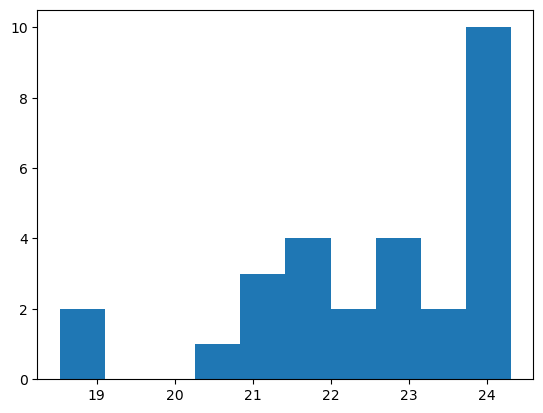

In [40]:
plt.hist(forced_phot['mag'])
plt.show()

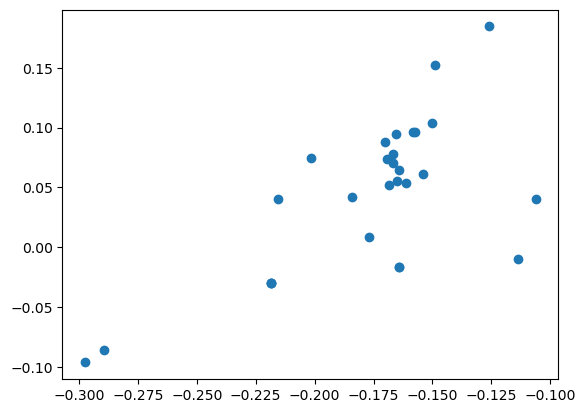

In [41]:
plt.scatter(forced_phot['v_ra'], forced_phot['v_dec'])
plt.show()